# What is a classification problem

* Binary classification: Target can be one of two options, e.g. yes or no	Predict whether or not someone has heart disease based on their health parameters.

* Multi-class classification: Target can be one of more than two options	Decide whether a photo is of food, a person or a dog.

* Multi-label classification: Target can be assigned more than one option	Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy).

# 0. Architecture of a classification neural network

 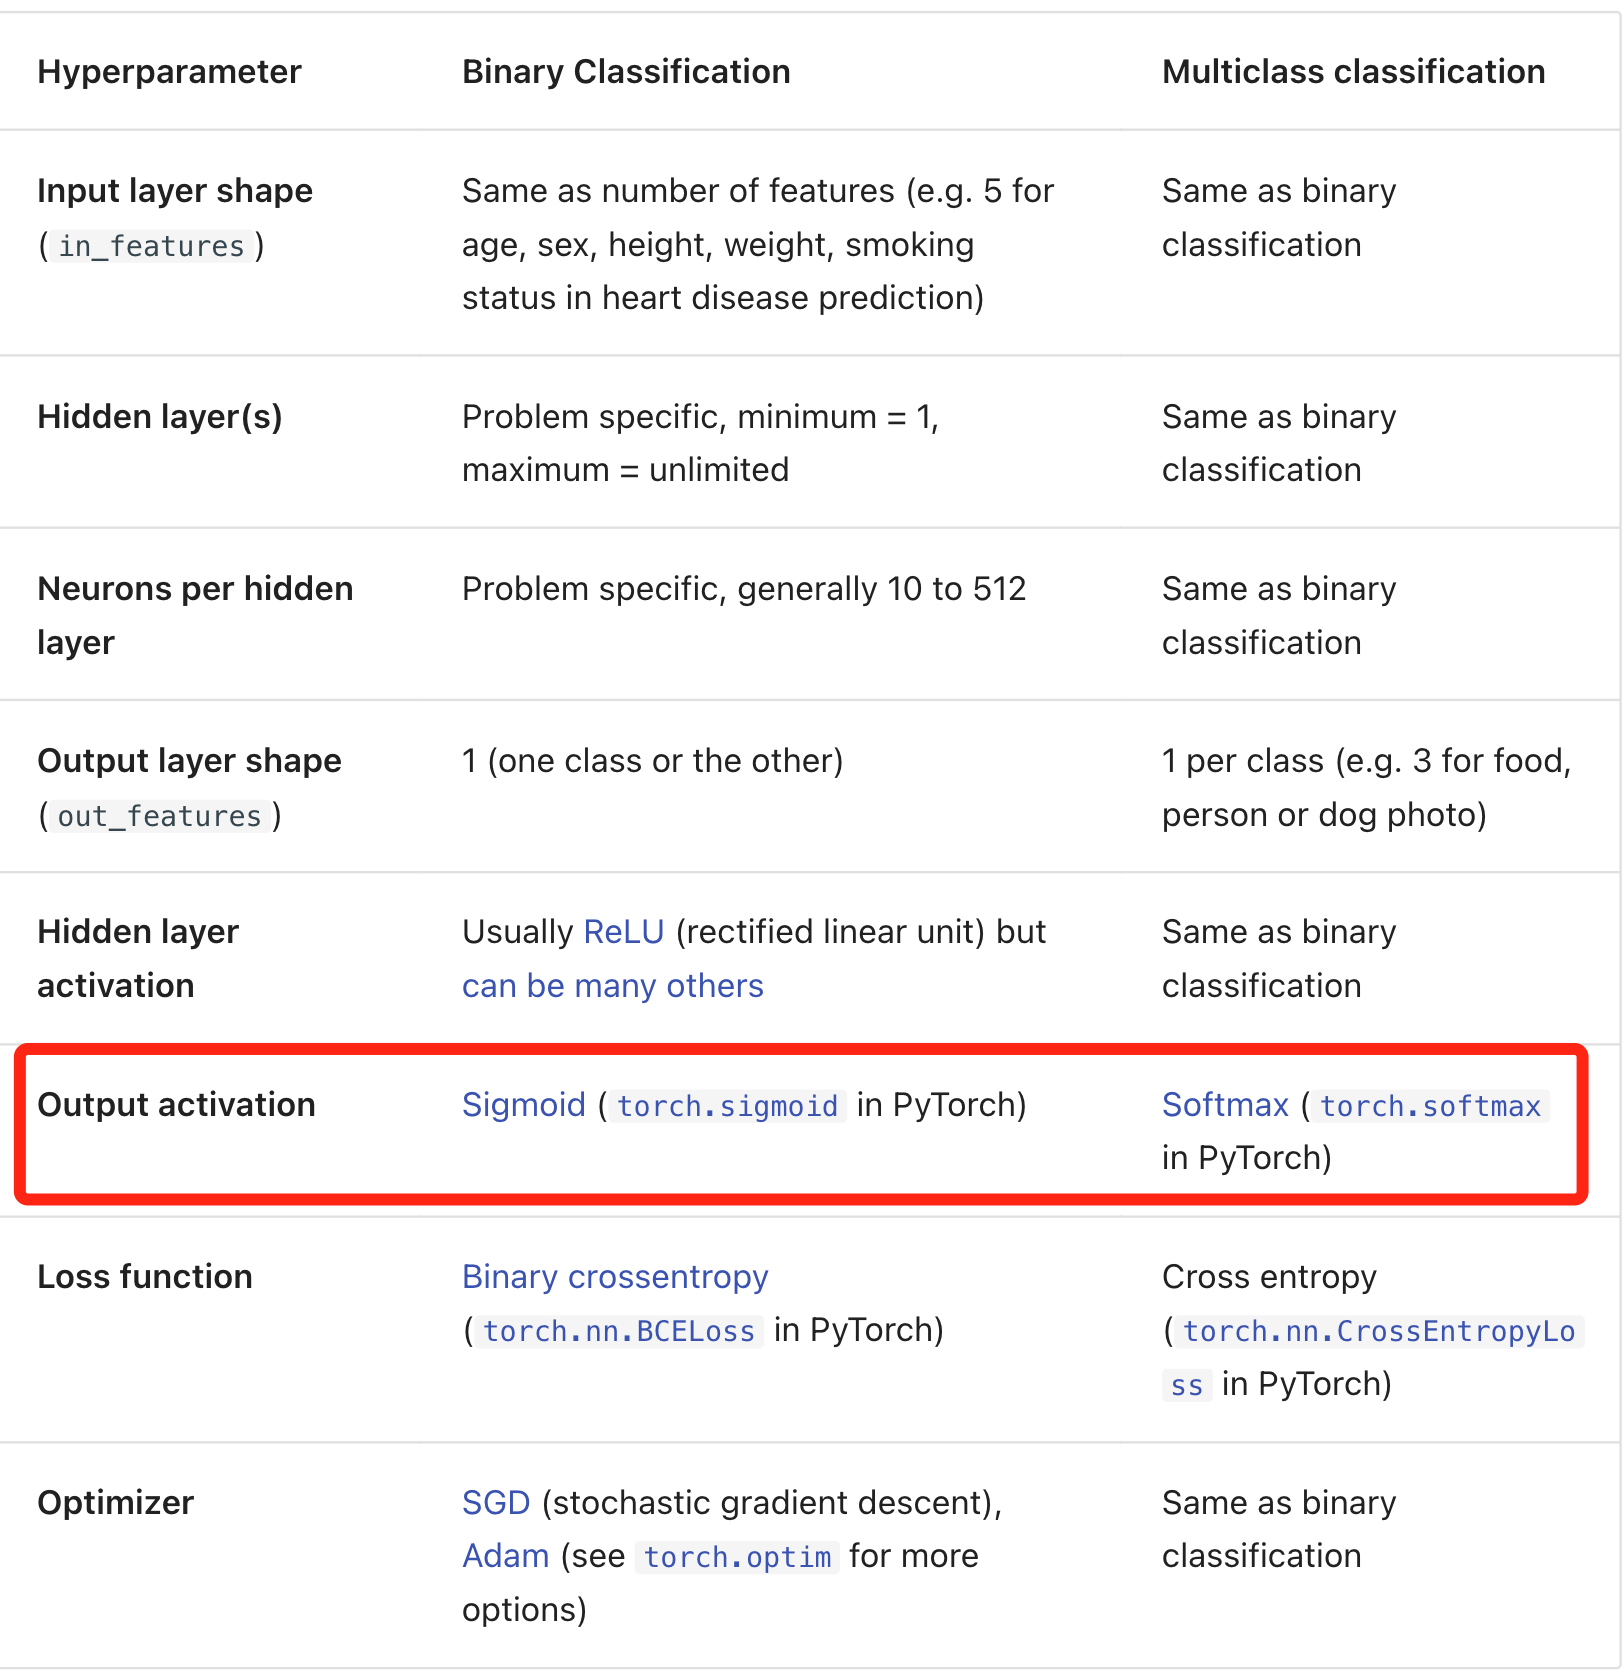

# 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({'x1':X[:,0],'x2':X[:,1],'label':y})

circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

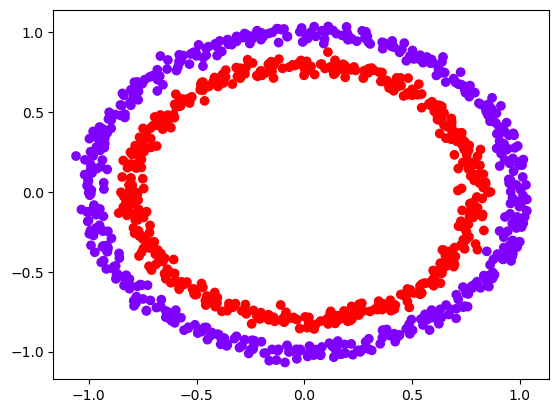

In [5]:
import matplotlib.pyplot as plt

plt.scatter(circles['x1'],circles['x2'],c=circles['label'],cmap='rainbow')

## 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a model

In [14]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [15]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
torch.__version__

'2.5.1'

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.6994],
        [0.5871],
        [0.9508],
        [0.6284],
        [0.8824],
        [0.8143],
        [0.5522],
        [0.6052],
        [0.9533],
        [0.5788]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

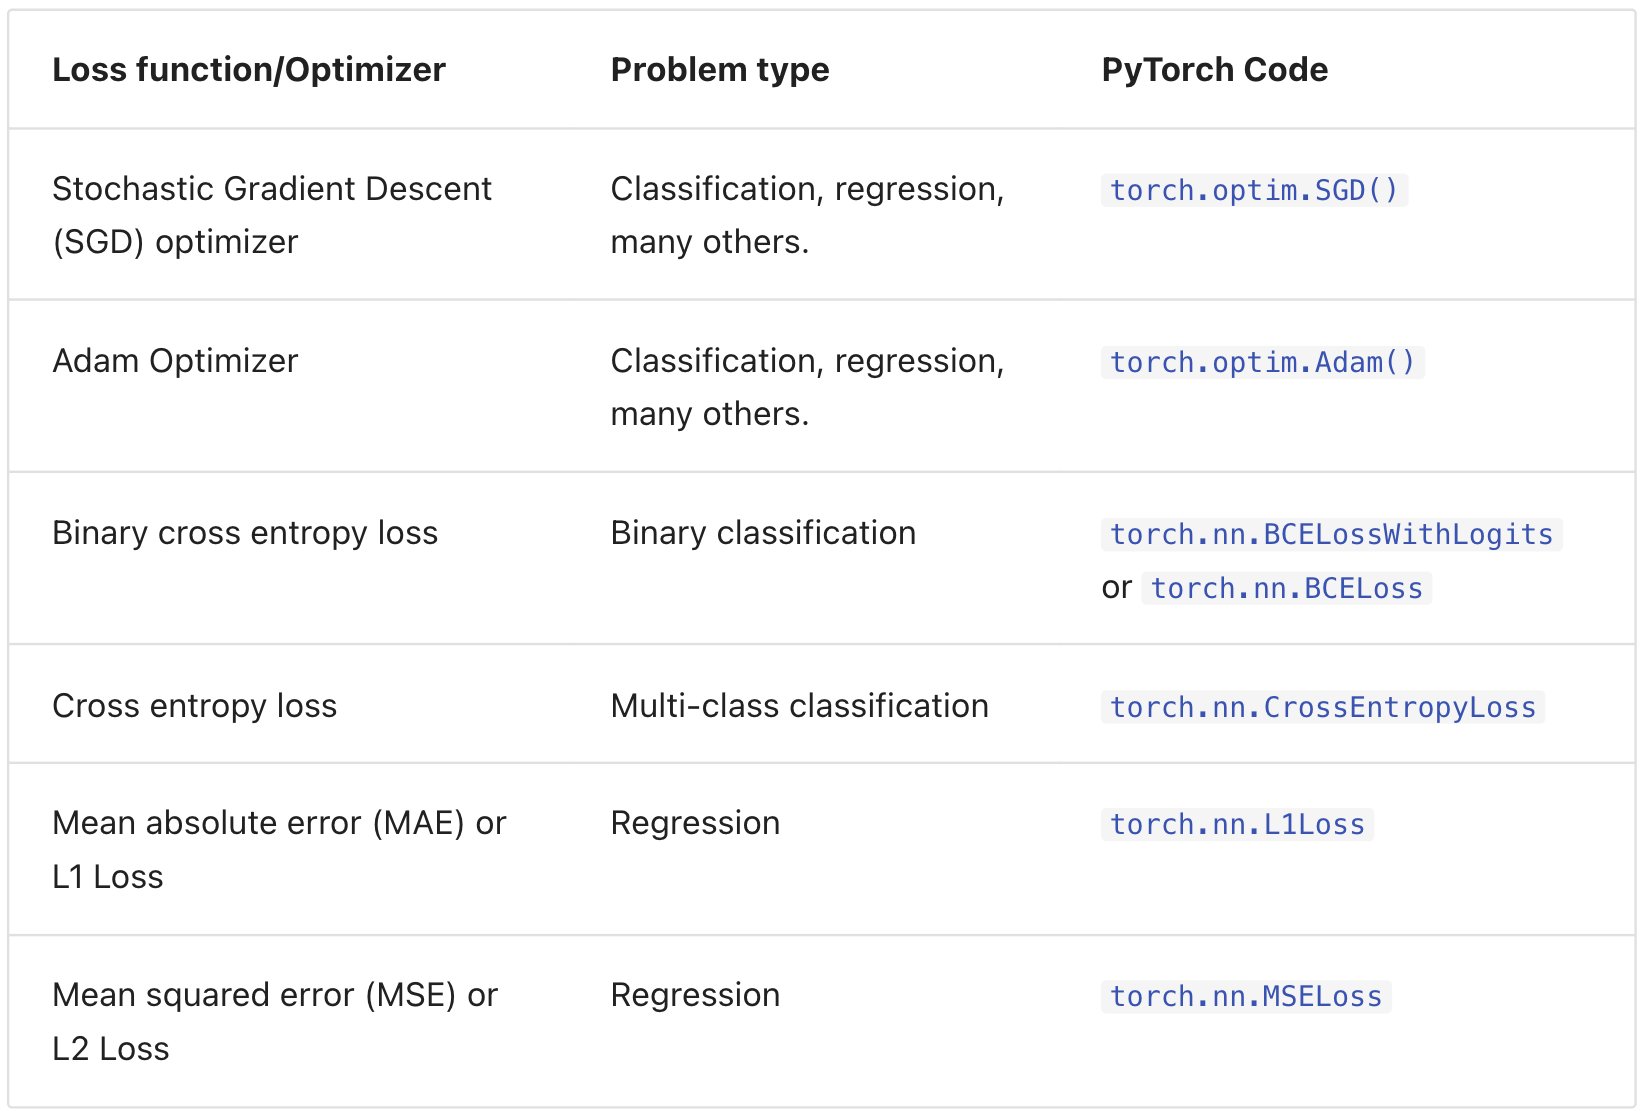

In [17]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

## 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [19]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6994],
        [0.5871],
        [0.9508],
        [0.6284],
        [0.8824]], device='mps:0', grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6681],
        [0.6427],
        [0.7213],
        [0.6521],
        [0.7073]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [24]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
print(y_preds.squeeze())
# print(y_preds)

tensor([True, True, True, True, True], device='mps:0')
tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)


In [29]:
y_test[:5], y_preds.squeeze()[:5]

(tensor([1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SliceBackward0>))

In [31]:
len(y_test), len(y_preds.squeeze())

(200, 5)

In [34]:
accuracy_fn(y_test.to(device)[:5], y_preds.squeeze().to(device))

60.0

## 3.2 Building a training and testing loop

In [35]:
%time
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training mode
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing mode
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

CPU times: user 3 μs, sys: 3 μs, total: 6 μs
Wall time: 14.1 μs
Epoch: 0 | Loss: 0.77338, Accuracy: 50.00% | Test loss: 0.75386, Test acc: 50.00%
Epoch: 10 | Loss: 0.71545, Accuracy: 50.00% | Test loss: 0.70686, Test acc: 50.00%
Epoch: 20 | Loss: 0.69995, Accuracy: 50.00% | Test loss: 0.69502, Test acc: 50.00%
Epoch: 30 | Loss: 0.69571, Accuracy: 57.88% | Test loss: 0.69222, Test acc: 61.00%
Epoch: 40 | Loss: 0.69450, Accuracy: 51.88% | Test loss: 0.69170, Test acc: 53.00%
Epoch: 50 | Loss: 0.69409, Accuracy: 50.00% | Test loss: 0.69170, Test acc: 53.00%
Epoch: 60 | Loss: 0.69391, Accuracy: 49.62% | Test loss: 0.69181, Test acc: 53.50%
Epoch: 70 | Loss: 0.69380, Accuracy: 49.00% | Test loss: 0.69193, Test acc: 54.50%
Epoch: 80 | Loss: 0.69371, Accuracy: 48.62% | Test loss: 0.69204, Test acc: 53.50%
Epoch: 90 | Loss: 0.69364, Accuracy: 49.00% | Test loss: 0.69214, Test acc: 52.50%


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

# 4. Make predictions and evaluate the model

In [36]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

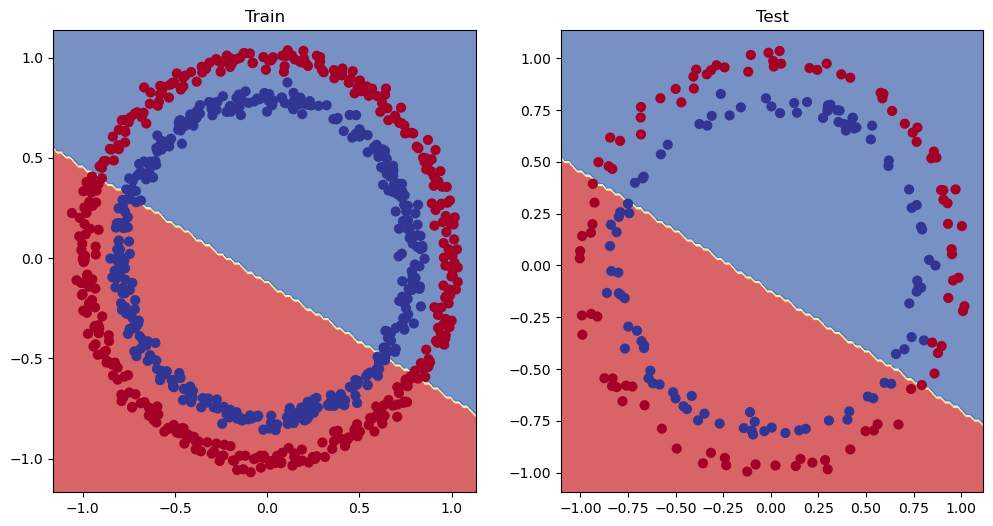

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)